#Chaper 3 통계적 실험과 유의성 검정

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
%cd /content/drive/MyDrive/Colab Notebooks/New Hobby/데이터 과학을 위한 통계/practicalstatisticsfordatascientists/python

/content/drive/MyDrive/Colab Notebooks/New Hobby/데이터 과학을 위한 통계/practicalstatisticsfordatascientists/python


In [30]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [31]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [32]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

#3.1 A/B 검정

##용어정리
- 처리 : 어떤 대상에 주어지는 특별한 환경이나 조건
- 처리군(처리 그룹) : 특정 처리에 노출된 대상들의 집단
- 대조군(대조 그룹) : 어떤 처리도 하지 않은 대상들의 집단
- 임의화(랜덤화) : 처리를 적용할 대상을 임의로 결정하는 과정
- 대상 : 처리를 적용할 개체 대상
- 검정통계량 : 처리 효과를 측정하기 위한 지표

A/B 검정의 예시
- 종자 발아가 어디에서 더 잘되는지 알아보기 위해 두 가지 토양 처리를 검정한다.
- 두 가지 가격을 검정하여 더 많은 순이익을 산출하는 쪽을 결정한다.
- 두 개의 인터넷 광고를 검정하여 어느 것이 더 높은 전환율을 얻을 지 판단한다.

##주요개념
- 연구 대상을 두 가지 이상의 그룹 중 하나에 할당한다. 여기서 서로 다른 처리 조건을 제외한 나머지 조건들은 동일하게 처리한다.
- 이상적으로, 대상들은 그룹에 무작위로 배정한다.

#3.2 가설검정

##용어정리
- 가설검정(유의성검정) : 관찰된 효과가 우연에 의한 것인지 알아내는 과정
- 귀무가설 : 우연 때문이라는 가설
- 대립가설 : 귀무가설과의 대조 (증명하고자하는 가설)
- 일원검정 : 한 방향으로만 우연히 일어날 확률을 계산하는 가설검정
- 이원검정 : 양방향으로 우연히 일어날 확률을 계산하는 가설검정

임의성에 함정에 빠지지 말자.

확률과 실제는 구분되어 생각해야한다. 0.5의 확률을 가지는 동전던지기의 경우에도 4번의 시행에서 모두 앞면이 나올 수 있다.

가설 검정은, 그룹 간의 차이가 우연에 의해서 생기는 것이 아니라는 것을 보이기 위해,

그룹들의 결과는 동일하며 그 차이는 우연에 의해 발생한 것이라는 귀무가설을 세워,

귀무가설이 틀렸다는 것을 보이는 과정이다.

다시 말해, 가설 검정은 귀무가설을 기각하는 과정이다.

이때 결과적으로 우리가 증명해야하는 가설은 귀무가설의 대조인 대립가설이다.



- 일원 가설검정 : 방향성(단방향)을 고려한 대립가설이 필요한 경우 (B가 A보다 낫다 등) 사용. 우연에 의한 극단적인 결과에 대해 한 방향만을 고려하여 p-value를 구한다. (기본값이 지정되어있는 경우. 예를 들면 A/B 검정)

- 이원 가설 검정 : 양방향을 고려한 대립가설이 필요한 경우 (A는 B와 다르며, 더 크가나 더 작을 수 있다.) 사용. 우연에 의한 극단적인 결과가 양쪽에서 나타날 p-value를 구한다.

##주요개념
- 귀무가설은 우리가 관찰한 어떤 효과가 특별한 것이 아니고, 우연에 의해 발생한 것이라는 개념을 구체화하는 일종의 논리적 구조이다.
- 가설검정은 귀무가설이 사실이라고 가정하고, '영모형(null model)' (probalbility model)을 생성하여 관찰한 효과가 해당 모델로부터 합리적으로 나올 수 있는 결과인지를 검증하는 것이다.

#3.3 재표본추출

##용어정리
- 순열검정(permutation test) : 두 개 이상의 표본을 함께 결합하여 관측값들을 무작위로(또는 전부를) 재표본으로 추출하는 과정
- 재표본추출 : 관측 데이터로부터 반복해서 표본추출하는 과정
- 복원/비복원 : 표본 추출 시, 이미 한번 뽑은 데이터를 다음번 추출을 위해 다시 제자리에 돌려 놓거나 / 다음 추출에서 제외하는 표본 추출방법

순열 절차
1. 여러 그룹(A, B, C, D ...)의 결과를 단일 데이터 집합으로 결합한다.
2. 결합된 데이터를 잘 섞은 후, 그룹 A와 동일한 크기의 표본을 무작위로 (비복원) 추출한다.
3. 나머지 데이터에서 그룹 B와 동일한 크기의 샘플을 무작위로(비복원) 추출한다.
4. C, D 등의 그룹에 대해서도 동일한 작업을 수행한다.
  - 이제 원본 표본의 크기를 반영하는 재표본을 수집했다.
5. 원래 샘플에 대해 구한 통계량 또는 추정치가 무엇이었든 간에 지금 추출한 재표본에 대해 모두 다시 계산하고 기록한다.
  - 이것으로 한 번의 순열 반복이 진행된다,
6. 앞선 단계들을 R번 반복하여 검정통계량의 순열분포를 얻는다.

순열 분포의 결과를 통해, 관찰된 차이가 순열로 보이는 차이의 집합 안에 있다면, 관찰된 차이가 우연에 의해 발생할 수 있는 범위 안에 있다는 의미다.

하지만, 관찰된 차이의 대부분이 순열분포 바깥에 있다면, 이것을 통계적으로 유의미하다고 할 수 있다.

In [33]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

Text(0.5, 0.98, '')

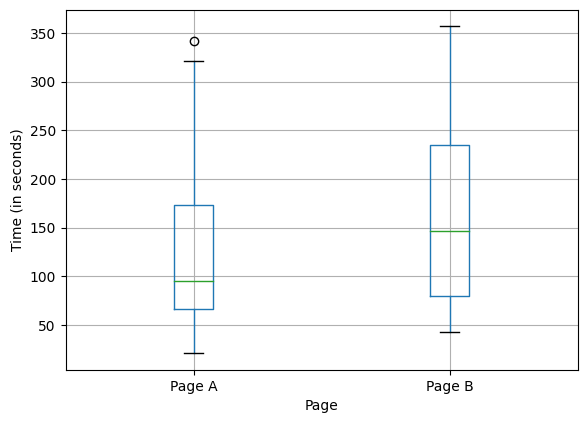

In [34]:
# 페이지에 머문 시간의 측정 분포
ax = session_times.boxplot(by='Page', column='Time')
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.title('')
plt.suptitle('')

In [35]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(f'Difference of Each Mean: {mean_b - mean_a}')

Difference of Each Mean: 35.66666666666667


In [36]:
'''
세션시간의 차이가 통계적으로 유의미한 것인지 확인하기 위해,
모든 세션 시간을 결합한 후, 잘 섞고 21개를 A그룹에, 나머지 15개는 B그룹에 재배치한다.
'''

# nA와 nB 설정
nA = 21
nB = 15

# 순열검정 함수
def perm_fun(x, nA, nB):
  n = nA + nB
  idx_B = set(random.sample(range(n) , nB)) #nB개의 표본을 추출하고, 그룹 B에 할당한다.
  idx_A = set(range(n)) - idx_B #나머지 nA개의 표본을 그룹 A에 할당한다.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.

In [37]:
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)] # R=1000

<ipython-input-36-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-36-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-36-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-36-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-36-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise 

Text(0, 0.5, 'Frequency')

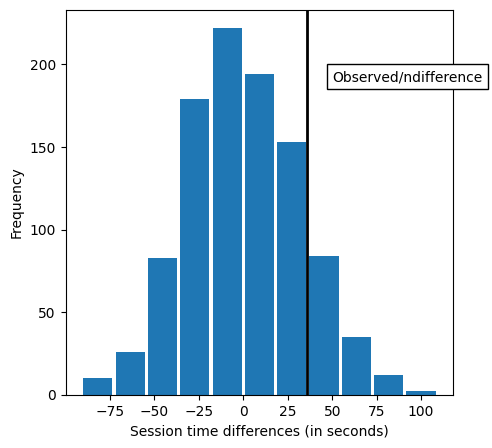

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b-mean_a, color='k', lw=2)
ax.text(50,190, 'Observed/ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

In [39]:
print(np.mean(np.array(perm_diffs) > mean_b-mean_a))
# 대부분의 80% 이상의 차이가 확률분포 범위의 내에 있다. -> 통계적으로 유의하지 않다.

0.138


- 전체순열검정(정확검정) : 데이터를 무작위로 섞고 나누는 대신, 실제로 나눌 수 있는 모든 가능한 조합을 찾는다. (샘플의 크기가 작을 때 용이)

- 부트스트랩 순열검정 : 비복원 추출 대신 '복원 추출'로 수행한다.

## 주요개념
- 순열검정에서는 여러 표본을 결합한 다음 잘 섞는다.
- 그런 다음 섞인 값들을 이용해 재표본추출 과정을 거쳐, 관심있는 표본통계량을 계산한다.
- 이 과정을 반복하고 재표본추출한 통계를 도표화한다.
- 관측된 통계량을 재표본한 분포와 비교하면 샘플 간에 관찰된 차이가 우연에 의한 것인지를 판단할 수 있다.

#3.4 통계적 유의성과 p 값

- 통계적 유의성: 통계 연구 결과가 우연히 일어난 것인지 아니면 우연히 일어날 수 없는 극단적인 것인지를 판단하는 방법

##용어정리
- p 값 (p-value) : 귀무가설을 구체화한 기회 모델이 주어졌을 때, 관측된 결과와 같이 특이하거나 극단적인 결과를 얻을 확률
- 알파 ($α$) : 실제 결과를 통계적으로 의미 있는 것으로 간주되기 위해, 우연에 의한 결과가 능가해야하는 '비정상적인' 가능성의 임계 확률
- 제 1종 오류 : 우연에 의한 효과를 실제 효과라고 잘못 결론 내리는 것
- 제 2종 오류 : 실제 효과를 우연에 의한 효과라고 잘못 결론 내리는 것

In [43]:
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed Difference: {obs_pct_diff:.4f}%')

Observed Difference: 0.0368%


Observed Difference: 0.0368%


<ipython-input-36-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-36-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-36-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-36-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return x.loc[idx_B].mean() - x.loc[idx_A].mean() #재배치한 그룹의 평균의 차이를 구한다.
<ipython-input-36-2a776bd2cea1>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise 

Text(0, 0.5, 'Frequency')

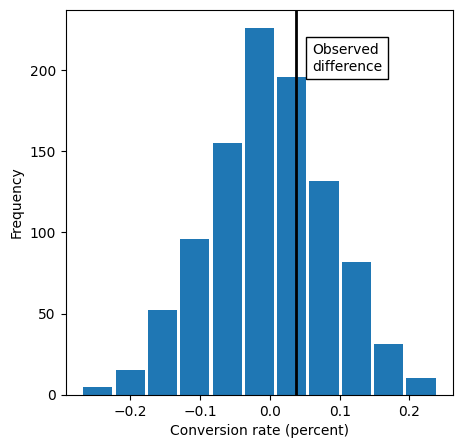

In [40]:
conversion = [0] * 45945
conversion.extend([1]*382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5,5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='k', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

In [42]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


- p-value
1. p-value는 이 데이터가 특정 통계 모델과 얼마나 상반되는지 나타낼 수 있다.
2. p-value는 연구 가설이 사실일 확률이나, 데이터가 랜덤하게 생성되었을 확률을 측정하는 것이 아니다.
3. 과학적 결론, 비즈니스나 정책 결정은 p 값이 특정 임계값을 통과하는지 여부를 기준으로 해서는 안된다.
4. 적절한 추론을 위해서는 완전한 보고와 투명성이 요구된다.
5. p-value 또는 통계적 유의성은 효과의 크기나 결과의 중요성을 의미하지는 않는다.
6. p 값 그 자체는 모델이나 가설에 대한 증거를 측정하기 위한 좋은 지표가 아니다.
---


##주요개념
- 유의성검정은 관찰된 효과가 귀무가설 모형에 대한 무작위 변이의 범위 내에 있는지 결정하는데 사용된다.
- p 값은 귀무가설로부터 나올 수 있는 결과가 관찰된 결과만큼 극단적으로 나타날 확률이다.
- 유의수준(알파)이란, 귀무가설 모델에서 '비정상'이라고 판단할 임곗값을 말한다.
- 유의성검증은 데이터 과학보다는 좀 더 공식적인 연구 보고 와 관련되어 있다.